In [1]:
from data_read import *
from net import *
import matplotlib.pyplot as plt
import numpy as np

import argparse

import os




parser = argparse.ArgumentParser()


parser.add_argument('--dataset_name', action="store", dest= "dataset_name",default="GoogleMap",help='MSCOCO')

parser.add_argument('--batch_size', action="store", dest="batch_size", type=int, default=1,help='batch_size')

parser.add_argument('--epoch_load_one', action="store", dest="epoch_load_one", type=int, default=20,help='load the epoch number from level one')

parser.add_argument('--epoch_load_two', action="store", dest="epoch_load_two", type=int, default=20,help='load the epoch number from level two')

parser.add_argument('--epoch_load_three', action="store", dest="epoch_load_three", type=int, default=20,help='load the epoch number from level three')

parser.add_argument('--epoch_load_four', action="store", dest="epoch_load_four", type=int, default=20,help='load the epoch number from level three')



parser.add_argument('-f')
input_parameters = parser.parse_args()



gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2000)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)




load_path_one='./checkpoints/'+input_parameters.dataset_name+'/level_one/'

'''
load_path_two='./checkpoints/'+input_parameters.dataset_name+'/level_two/'

load_path_three='./checkpoints/'+input_parameters.dataset_name+'/level_three/'

load_path_four='./checkpoints/'+input_parameters.dataset_name+'/level_four/'
'''




level_one_network=Level_one()
level_one_network.load_weights(load_path_one + 'epoch_'+str(input_parameters.epoch_load_one)+"_full")
'''
level_two_network=Level_two()
level_two_network.load_weights(load_path_two + 'epoch_'+str(input_parameters.epoch_load_two)+"_full")

level_three_network=Level_three()
#level_three_network.load_weights(load_path_three + 'epoch_'+str(input_parameters.epoch_load_three)+"_full")

level_four_network=Level_four()
level_four_network.load_weights(load_path_four + 'epoch_'+str(input_parameters.epoch_load_four)+"_full")
'''


def initial_motion():
    # prepare source and target four points
    matrix_list=[]
    for i in range(input_parameters.batch_size):
       
        src_points=[[0,0],[127,0],[127,127],[0,127]]

        tgt_points=[[32,32],[160,32],[160,160],[32,160]]

    
        src_points=np.reshape(src_points,[4,1,2])
        tgt_points=np.reshape(tgt_points,[4,1,2])

        # find homography
        h_matrix, status = cv2.findHomography(src_points, tgt_points,0)
        matrix_list.append(h_matrix)
    return np.asarray(matrix_list).astype(np.float32)

def construct_matrix(initial_matrix,scale_factor,batch_size):
    #scale_factor size_now/(size to get matrix)
    initial_matrix=tf.cast(initial_matrix,dtype=tf.float32)
    
    scale_matrix=np.eye(3)*scale_factor
    scale_matrix[2,2]=1.0
    scale_matrix=tf.cast(scale_matrix,dtype=tf.float32)
    scale_matrix_inverse=tf.linalg.inv(scale_matrix)

    scale_matrix=tf.expand_dims(scale_matrix,axis=0)
    scale_matrix=tf.tile(scale_matrix,[batch_size,1,1])

    scale_matrix_inverse=tf.expand_dims(scale_matrix_inverse,axis=0)
    scale_matrix_inverse=tf.tile(scale_matrix_inverse,[batch_size,1,1])

    final_matrix=tf.matmul(tf.matmul(scale_matrix,initial_matrix),scale_matrix_inverse)
    return final_matrix



def average_cornner_error(batch_size,predicted_matrix,u_list,v_list,top_left_u=0,top_left_v=0,bottom_right_u=127,bottom_right_v=127):
    
    four_conner=[[top_left_u,top_left_v,1],[bottom_right_u,top_left_v,1],[bottom_right_u,bottom_right_v,1],[top_left_u,bottom_right_v,1]]
    four_conner=np.asarray(four_conner)
    four_conner=np.transpose(four_conner)
    four_conner=np.expand_dims(four_conner,axis=0)
    four_conner=np.tile(four_conner,[batch_size,1,1]).astype(np.float32)
    
    new_four_points=tf.matmul(predicted_matrix,four_conner)
    
    new_four_points_scale=new_four_points[:,2:,:]
    new_four_points= new_four_points/new_four_points_scale
    
    
    u_predict=new_four_points[:,0,:]
    v_predict=new_four_points[:,1,:]
    
    average_conner=tf.sqrt(tf.math.pow(u_predict-u_list,2)+tf.math.pow(v_predict-v_list,2))
    #print (np.shape(average_conner))
    average_conner=tf.reduce_mean(average_conner)
    
    
    return average_conner
    


def loss_function(batch_size,initial_matrix,predicted_matrix,u_list,v_list,alpha,top_left_u=0,top_left_v=0,bottom_right_u=127,bottom_right_v=127):
    d_cornner=average_cornner_error(batch_size,predicted_matrix,u_list,v_list,top_left_u,top_left_v,bottom_right_u,bottom_right_v)
    
    d_cornner_initial=average_cornner_error(batch_size,initial_matrix,u_list,v_list,top_left_u,top_left_v,bottom_right_u,bottom_right_v)

    delta=d_cornner_initial-tf.math.pow(tf.math.maximum(0,tf.math.sqrt(d_cornner_initial)-2*alpha),2)

    #print (delta)
    total_loss=tf.math.maximum(0,1+delta+d_cornner-d_cornner_initial)
    #print (d_cornner)
    #print (d_cornner_initial)

    #print (total_loss)
    return total_loss




LK_layer_one=Lucas_Kanade_layer(batch_size=1,height_template=16,width_template=16,num_channels=4)


LK_layer_two=Lucas_Kanade_layer(batch_size=1,height_template=32,width_template=32,num_channels=4)


LK_layer_three=Lucas_Kanade_layer(batch_size=1,height_template=64,width_template=64,num_channels=4)


LK_layer_four=Lucas_Kanade_layer(batch_size=1,height_template=128,width_template=128,num_channels=4)


initial_matrix=initial_motion()
initial_matrix_scaled=construct_matrix(initial_matrix,scale_factor=0.125,batch_size=input_parameters.batch_size)


1 Physical GPUs, 1 Logical GPUs


In [2]:
data_loader=data_loader_GoogleMap('val')
fk_loop=25

888


In [3]:
#file = open("./CLKN_GoogleMap.txt","w") 

count_sub=0
for i in range(6000):
    input_img,u_list,v_list,template_img=data_loader.data_read_batch(batch_size=input_parameters.batch_size)
    
    input_img=input_img
    template_img=template_img
    
    input_feature_one=level_one_network.call(input_img,training=False)
        
    template_feature_one=level_one_network.call(template_img,training=False)

    updated_matrix_one=LK_layer_one.update_matrix(template_feature_one,input_feature_one,initial_matrix_scaled)


    '''
 
    for j in range(fk_loop):
        try:
            updated_matrix_one=LK_layer_one.update_matrix(template_feature_one,input_feature_one,updated_matrix_one)
        except:
            break
         
    updated_matrix_one=construct_matrix(updated_matrix_one,scale_factor=2,batch_size=input_parameters.batch_size)

    input_feature_two=level_two_network.call(input_img,training=False)
        
    template_feature_two=level_two_network.call(template_img,training=False)

    updated_matrix_two=LK_layer_two.update_matrix(template_feature_two,input_feature_two,updated_matrix_one)

    for j in range(fk_loop):
        try:
            updated_matrix_two=LK_layer_two.update_matrix(template_feature_two,input_feature_two,updated_matrix_two)
        except:
            break
  
    updated_matrix_two=construct_matrix(updated_matrix_two,scale_factor=2,batch_size=input_parameters.batch_size)

    input_feature_three=level_three_network.call(input_img,training=False)
        
    template_feature_three=level_three_network.call(template_img,training=False)

    updated_matrix_three=LK_layer_three.update_matrix(template_feature_three,input_feature_three,updated_matrix_two)

    
    for j in range(fk_loop):
        try:
            updated_matrix_three=LK_layer_three.update_matrix(template_feature_three,input_feature_three,updated_matrix_three)
        except:
            break
    
    updated_matrix_three=construct_matrix(updated_matrix_three,scale_factor=2,batch_size=input_parameters.batch_size)
    
    

    input_feature_four=level_four_network.call(input_img,training=False)
        
    template_feature_four=level_four_network.call(template_img,training=False)

    feature=LK_layer_four.projective_inverse_warp(input_feature_four,updated_matrix_three)
    updated_matrix_four=LK_layer_four.update_matrix(template_feature_four,input_feature_four,updated_matrix_three)

    
  
    for j in range(fk_loop):
        try:
            updated_matrix_four=LK_layer_four.update_matrix(template_feature_four,input_feature_four,updated_matrix_four)
        except:
            break
    
    '''
    predicted_matrix=updated_matrix_one
    
    
    

    
   
    cornner_error=average_cornner_error(1,predicted_matrix,u_list,v_list,top_left_u=0,top_left_v=0,bottom_right_u=127,bottom_right_v=127)
    each_error=cornner_error
    print (i)
    print (np.float(each_error))
    if each_error<1.0:
        count_sub=count_sub+1
        print (count_sub/(i+1))
    break
    #file.write(str(np.float(each_error)))
    #file.write('\n')

#file.close()

0
87.6162338256836


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


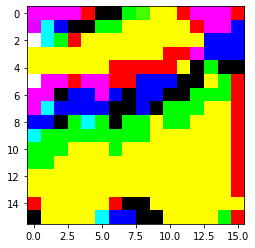

In [5]:
plt.imshow(template_feature_one[0,:,:,:3]*100)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


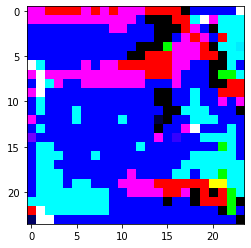

In [6]:
plt.imshow(input_feature_one[0,:,:,:3]*100)
plt.show()